In [1]:
import pandas as pd
import numpy as np
from climada.hazard import Hazard
import xarray as xr
# Rename columns

# Extract years from the `time` dimension
unique_years = np.arange(2003,2022)

# Initialize an empty list to store the hazards
yearly_hazards = {}

# Loop over each unique year
for year in unique_years:
    file = f"/Users/szelie/OneDrive - ETH Zurich/data/health_multi_risk_data/isimip3a/flood_fraction/cama-flood_ensemble_median_20crv3-era5_obsclim_histsoc_default_fldfrc_15arcmin_global_month-max_nopros_{year}.nc"

    yearly_hazard = xr.open_dataset(file)
    yearly_hazard = yearly_hazard.rename({"lat":"latitude", "lon":"longitude"})
    #yearly_hazard['longitude'] = yearly_hazard['longitude'].where(yearly_hazard['longitude'] <= 180, yearly_hazard['longitude'] - 360)

    # Convert it into a hazard
    yearly_hazard = Hazard.from_xarray_raster(yearly_hazard, hazard_type='RF', intensity_unit='fraction', intensity='fldfrc')
    # Append the hazard to the list
    yearly_hazards[year] = yearly_hazard
    #yearly_hazards[year].centroids.coord[:, 1] = yearly_hazards[year].centroids.coord[:, 1]-180

## Store the hazards in the hazards dictionary
#hazards['pm25_fire'] = Hazard.concat(yearly_hazards)


<GeoAxes: title={'center': 'RF max intensity at each point'}>

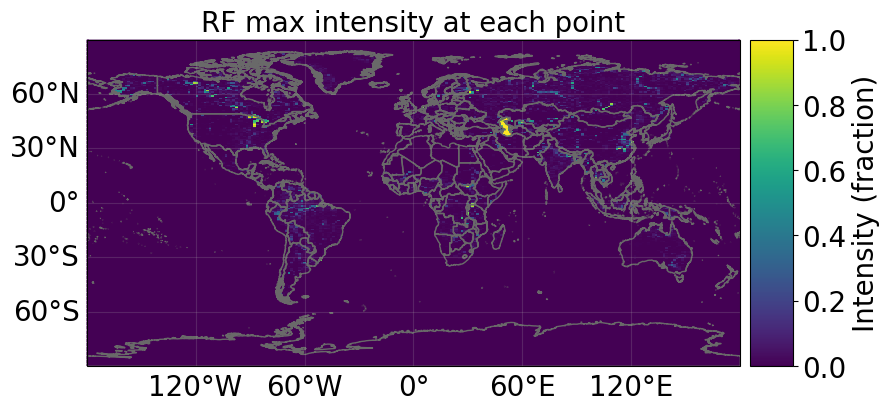

In [2]:
yearly_hazards[2021].plot_intensity(0)

In [3]:
from pathlib import Path
from climada.entity import Exposures
import numpy as np
exposures_dict = {}
path_exposures = Path("/Users/szelie/OneDrive - ETH Zurich/data/health_multi_risk_data/worldpop/climada_exposures")


for age in ['0_1', '65_70_75_80']:
    exposures_dict[age] = {}
    for year in np.arange(2003, 2023):
        year = str(year)
        exposures_dict[age][year] = Exposures.from_hdf5(path_exposures / f"{age}_era5_025_compatible_{year}.hdf5")
        exposures_dict[age][year].gdf["impf_RF"] = 1 
        exposures_dict[age][year].gdf['longitude'] = exposures_dict[age][year].gdf['longitude'].apply(lambda x: x - 360 if x > 180 else x)
        exposures_dict[age][year].gdf['value'][exposures_dict[age][year].gdf['value']<0] = 0


In [4]:
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet

impf_set = ImpactFuncSet()

impfhw = ImpactFunc()
impfhw.id = 1
impfhw.haz_type = 'RF'
impfhw.name = 'Step function rf'
impfhw.intensity_unit = ''
impfhw.intensity = np.array([0, 0.05, 0.5, 1])
impfhw.mdd = np.array([0, 0.05, 0.5, 1])
impfhw.paa = np.ones(impfhw.intensity.shape)
impfhw.check()
impf_set.append(impfhw)

<Axes: title={'center': 'RF 1: Step function rf'}, xlabel='Intensity ()', ylabel='Impact (%)'>

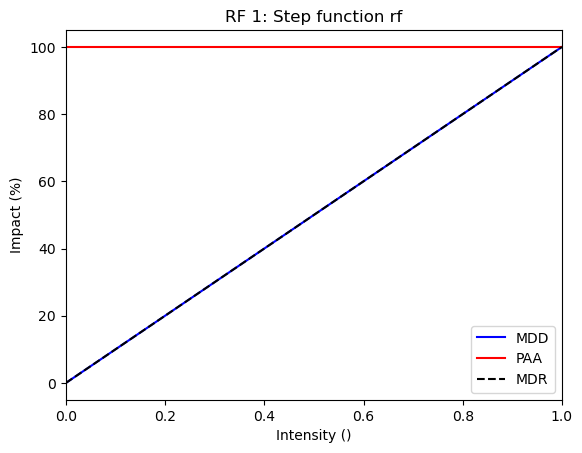

In [5]:
impfhw.plot()

In [6]:
from climada.engine import Impact, ImpactCalc

impact_dict={age:{year:ImpactCalc(exposures_dict[age][str(year)], impf_set, yearly_hazards[year]).impact(save_mat=True) for year in unique_years} for age in exposures_dict}
for age in impact_dict:
    for year in impact_dict[age]:
        impact_dict[age][year].tot_value=0

2024-06-16 17:52:58,383 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-06-16 17:52:58,385 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-06-16 17:52:58,385 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-06-16 17:52:58,385 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-06-16 17:52:58,386 - climada.engine.impact - WARNING - The 

In [7]:
impact_concat = {}
#impact_concat_no_change_vuln_pop = {}
for age in impact_dict:
    impact_concat[age] = Impact.concat(list(impact_dict[age].values()),reset_event_ids=True)
    #impact_concat_no_change_vuln_pop[age] = Impact.concat(list(impact_dict_no_change_vuln_pop[age].values()),reset_event_ids=True)

2024-06-16 17:52:58,398 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-06-16 17:52:58,399 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-06-16 17:52:58,399 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-06-16 17:52:58,399 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-06-16 17:52:58,400 - climada.engine.impact - WARNING - The 

In [8]:
impact_concat

{'0_1': <climada.engine.impact.Impact at 0x1963b7a90>,
 '65_70_75_80': <climada.engine.impact.Impact at 0x1962bf0d0>}

In [9]:
impact_concat['65_70_75_80'].at_event

array([ 5084083.76229045,  4521691.64482679,  4778150.34756911,
        5418919.30987559,  6034525.45624863,  7255687.0931112 ,
        8963550.84982115,  9020331.2035199 ,  8743839.34136357,
        8110564.68304283,  6584958.72572622,  5547779.2558978 ,
        4075100.45586852,  4913254.44422105,  4634724.95255821,
        4405758.02792331,  4933879.08262584,  6123072.69714122,
        7116504.45108604,  8728816.89666478,  8758629.26667528,
        8306744.5908339 ,  7525624.1259421 ,  6075325.09605691,
        5439770.02699188,  4688569.25301565,  4378880.17206343,
        4827888.640367  ,  5061137.59154042,  5848695.63136121,
        6887378.62590208,  9108808.90270153,  9290438.36834372,
        9195348.1015954 ,  8058641.77966142,  6567688.62458242,
        5386886.97215275,  4128061.29864187,  3090717.33076514,
        3569894.55153911,  4246365.85227337,  5006275.63807605,
        5771409.86802034,  6753926.66651422,  8375022.82436438,
        8162615.26854013,  7955047.12204

In [10]:
from util import *
for age in impact_dict:
    write_hazard(impact_concat[age], 'RF_nopros', age)